In [ ]:
# Install LangChain and its dependencies
!pip install langchain
!pip install langchain-community

# Install OpenAI library for integration
!pip install openai

# Install Py2Neo for Neo4j interaction
!pip install py2neo

# Install Pandas for data manipulation
!pip install pandas

# Install OpenPyXL for handling Excel files
!pip install openpyxl
# Install required libraries
!pip install --upgrade spacy py2neo pandas openpyxl
# Download SpaCy's English model
!python -m spacy download en_core_web_sm

!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.9 MB/s eta 0:00:00


Adding linear regression as a way to weigh the factors

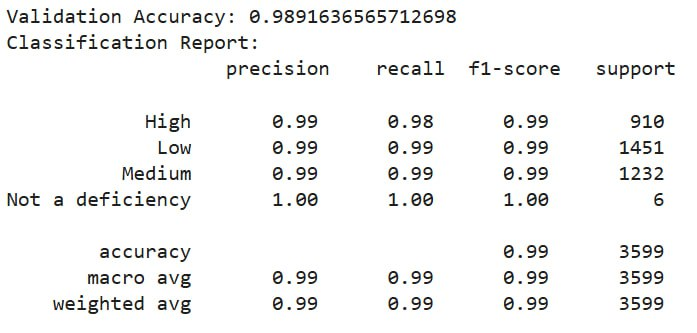

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load Data
def load_data(file_path):
    """Load the deficiency dataset from a CSV file."""
    return pd.read_csv("psc_severity_train.csv")

# Step 2: Derive Consensus Severity
def derive_consensus(data):
    """Derive consensus severity using majority voting."""
    consensus = data.groupby('PscInspectionId')['annotation_severity'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Medium')
    consensus = consensus.reset_index()
    data = data.merge(consensus, on='PscInspectionId', suffixes=('', '_Consensus'))
    return data

# Step 3: Compute Initial Features
def compute_initial_features(data, is_train=True):
    """Compute initial weighted features for all necessary columns."""
    # Normalize time differences
    data['time_diff'] = (pd.to_datetime(data['InspectionDate']) - pd.to_datetime(data['InspectionDate']).min()).dt.days
    data['time_diff_normalized'] = (data['time_diff'] - data['time_diff'].min()) / (data['time_diff'].max() - data['time_diff'].min())

    # Vessel type weights
    vessel_type_weights = {
        'Chemical': 1.5,
        'Dry Bulk': 1.2,
        'Container': 1.0,
        'Other': 0.8
    }
    data['vessel_type_weight'] = data['VesselGroup'].map(vessel_type_weights).fillna(1.0)

    # Port-based weights
    if is_train and 'annotation_severity_Consensus' in data.columns:
        port_severity = data.groupby('PortId')['annotation_severity_Consensus'].apply(lambda x: (x == 'High').mean())
        data['port_weight'] = data['PortId'].map(port_severity).fillna(0.5)
    else:
        data['port_weight'] = 0.5  # Default for test data

    # PscAuthorityId-based weights
    if is_train and 'annotation_severity_Consensus' in data.columns:
        authority_severity = data.groupby('PscAuthorityId')['annotation_severity_Consensus'].apply(lambda x: (x == 'High').mean())
        data['psc_authority_weight'] = data['PscAuthorityId'].map(authority_severity).fillna(0.5)
    else:
        data['psc_authority_weight'] = 0.5  # Default for test data

    # Annotator consistency
    if is_train and 'annotation_severity_Consensus' in data.columns:
        consistency = data.groupby('username').apply(
            lambda x: (x['annotation_severity'] == x['annotation_severity_Consensus']).mean()
        ).reset_index(name='average_consistency')
        data = data.merge(consistency, on='username', how='left')
    else:
        data['average_consistency'] = 0.5  # Default for test data

    return data

# Step 4: Optimize Weights Using Linear Regression
def optimize_weights(data):
    """Optimize feature weights using linear regression."""
    feature_columns = ['time_diff_normalized', 'vessel_type_weight', 'port_weight', 'psc_authority_weight', 'average_consistency']
    X = data[feature_columns]
    y = (data['annotation_severity_Consensus'] == 'High').astype(int)

    reg = LinearRegression()
    reg.fit(X, y)

    weights = dict(zip(feature_columns, reg.coef_))
    print("Optimized Weights:", weights)
    return weights

# Step 5: Compute Combined Weights
def compute_combined_weight(data, weights):
    """Compute a combined weight using optimized weights."""
    data['combined_weight'] = (
        data['time_diff_normalized'] * weights['time_diff_normalized'] +
        data['vessel_type_weight'] * weights['vessel_type_weight'] +
        data['port_weight'] * weights['port_weight'] +
        data['psc_authority_weight'] * weights['psc_authority_weight'] +
        data['average_consistency'] * weights['average_consistency']
    )
    return data

# Step 6: Preprocess Text Data
def preprocess_text(data, text_column):
    """Transform text data using TF-IDF Vectorization."""
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_text = vectorizer.fit_transform(data[text_column]).toarray()
    return X_text, vectorizer

# Step 7: Combine Features
def combine_features(X_text, data, additional_features):
    """Combine text features with additional numeric and weighted features."""
    X_additional = data[additional_features + ['combined_weight']].values
    return np.hstack((X_text, X_additional))

# Step 8: Train Prediction Model
def train_model(X, y):
    """Train a Random Forest Classifier."""
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Validation
    y_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))

    return model

# Step 9: Predict Severities for Test Set
def predict_severity(model, vectorizer, test_data, text_column, additional_features):
    """Predict severities for the test dataset."""
    X_text = vectorizer.transform(test_data[text_column]).toarray()
    X_test = combine_features(X_text, test_data, additional_features)
    predictions = model.predict(X_test)
    test_data['Predicted_Severity'] = predictions
    return test_data

# Main Workflow
if __name__ == "__main__":
    # Load training and test datasets
    train_data = load_data("psc_severity_train.csv")
    test_data = load_data("psc_severity_test.csv")
    print("Datasets loaded successfully.")

    # Derive consensus severity
    train_data = derive_consensus(train_data)

    # Compute initial features
    train_data = compute_initial_features(train_data, is_train=True)
    test_data = compute_initial_features(test_data, is_train=False)

    # Optimize weights using linear regression
    optimized_weights = optimize_weights(train_data)

    # Compute combined weights
    train_data = compute_combined_weight(train_data, optimized_weights)
    test_data = compute_combined_weight(test_data, optimized_weights)

    # Preprocess text data
    X_text, vectorizer = preprocess_text(train_data, text_column='def_text')
    y = (train_data['annotation_severity_Consensus'] == 'High').astype(int)

    # Combine text features with additional numeric and weighted features
    additional_features = ['time_diff_normalized', 'vessel_type_weight', 'port_weight', 'psc_authority_weight', 'average_consistency']
    X = combine_features(X_text, train_data, additional_features)

    # Train model
    model = train_model(X, y)

    # Predict on test set
    test_data = predict_severity(model, vectorizer, test_data, text_column='def_text', additional_features=additional_features)

    # Save predictions
    test_data.to_csv('predicted_severities.csv', index=False)
    print("Predictions saved to 'predicted_severities.csv'")

Datasets loaded successfully.


<ipython-input-36-79de03a90780>:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  consistency = data.groupby('username').apply(


Optimized Weights: {'time_diff_normalized': -0.0073409741323744206, 'vessel_type_weight': 0.10040381732355019, 'port_weight': 0.9925915618202334, 'psc_authority_weight': 0.045858157639326276, 'average_consistency': 0.3676515729603073}
Validation Accuracy: 0.9947207557654905
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2689
           1       1.00      0.98      0.99       910

    accuracy                           0.99      3599
   macro avg       1.00      0.99      0.99      3599
weighted avg       0.99      0.99      0.99      3599

Predictions saved to 'predicted_severities.csv'


neo4j knowledge grpah based on def_text column



```
# This is formatted as code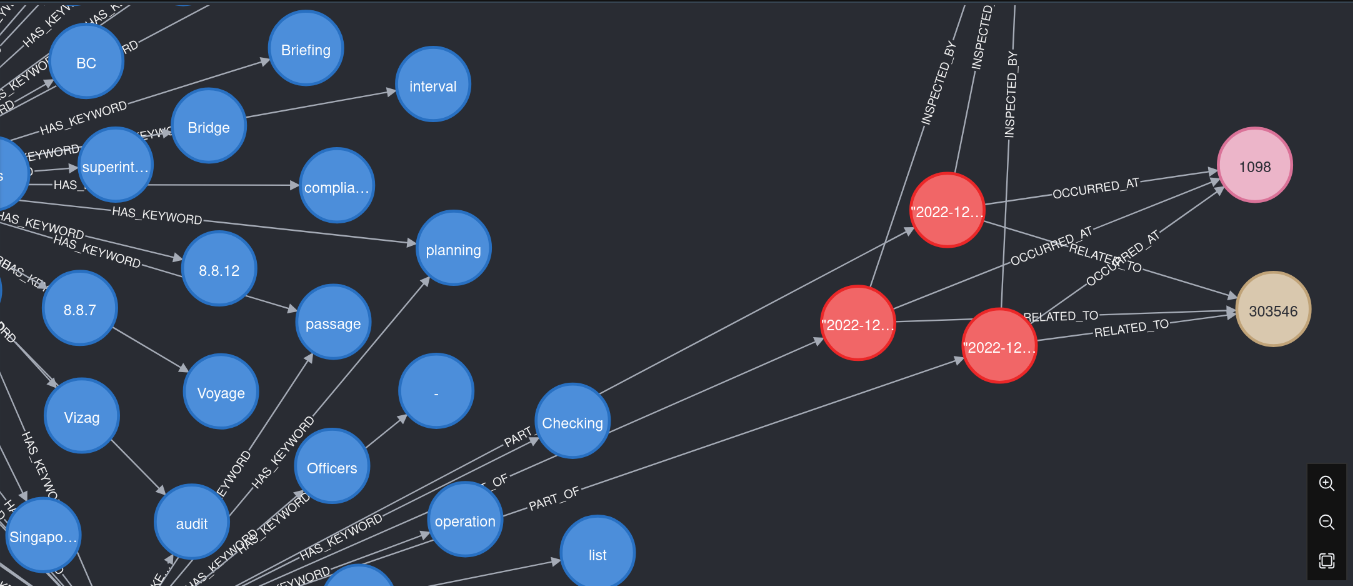
```



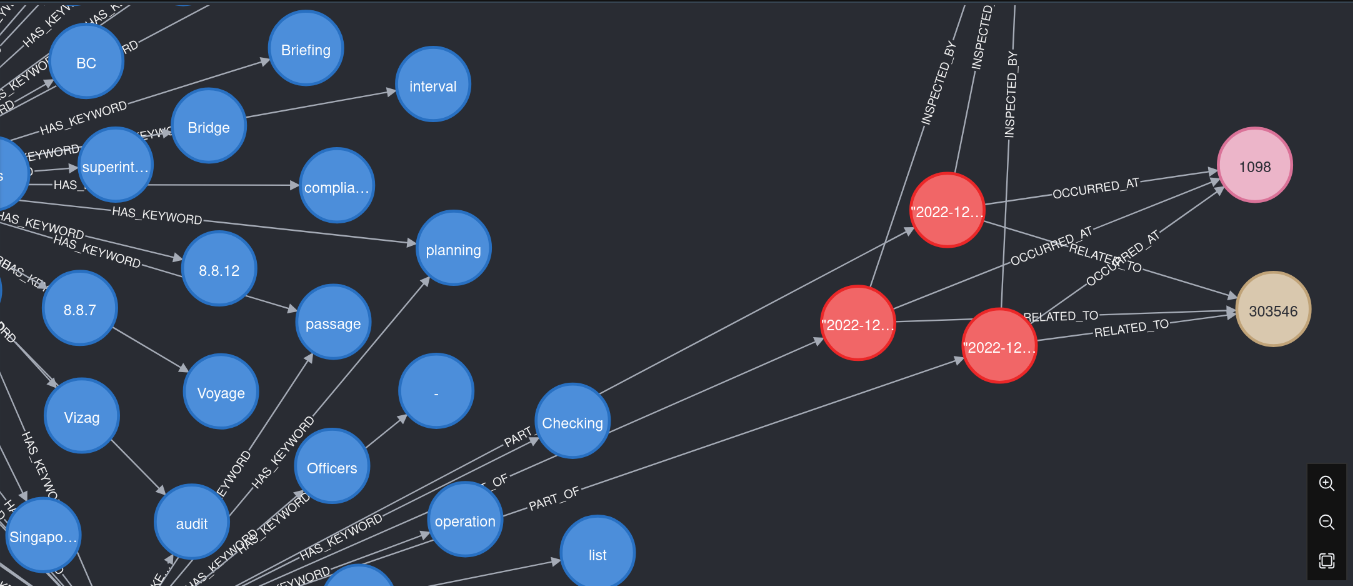

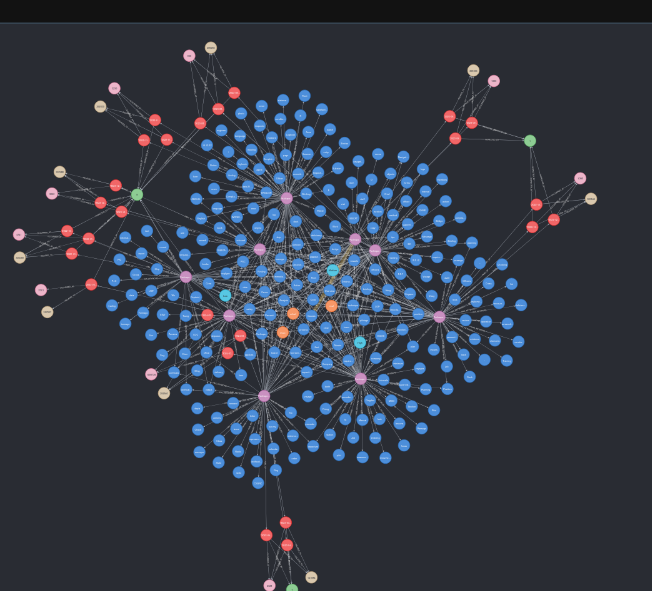



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
from transformers import pipeline
import spacy
from neo4j import GraphDatabase

def analyze_text_severity(text_column):
    """Analyze text severity using SpaCy, Hugging Face, and Neo4j."""
    classifier = pipeline("text-classification", model="distilbert-base-uncased", return_all_scores=True)
    nlp = spacy.load("en_core_web_sm")
    def calculate_severity(text):
        doc = nlp(text)
        word_scores = []
        for token in doc:
            if not token.is_stop and not token.is_punct:
                response = classifier(token.text)
                severity_map = {"High": 1.0, "Medium": 0.5, "Low": 0.2}
                predicted_severity = max(response, key=lambda x: x["score"])["label"]
                word_scores.append(severity_map.get(predicted_severity, 0.0))
        return np.mean(word_scores) if word_scores else 0.5
    return text_column.apply(calculate_severity)



In [ ]:
"""from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

# Load the training data with consensus severity
training_data = pd.read_excel("training_data_with_consensus.xlsx")

# Encode consensus severity
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
training_data["encoded_severity"] = label_encoder.fit_transform(training_data["consensus_severity"])

# Features and labels
X = training_data["def_text"]
y = training_data["encoded_severity"]

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF + Random Forest pipeline
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Validate the model
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# Save the trained model
joblib.dump(pipeline, "severity_prediction_model.pkl")"""


In [ ]:
"""# Load the test data
test_data = pd.read_excel("psc_severity_test.xlsx")

# Load the trained model
pipeline = joblib.load("severity_prediction_model.pkl")

# Predict severity
test_data["encoded_predicted_severity"] = pipeline.predict(test_data["def_text"])
test_data["predicted_severity"] = label_encoder.inverse_transform(test_data["encoded_predicted_severity"])

# Save the predictions
test_data[["PscInspectionId", "def_text", "predicted_severity"]].to_excel("test_predictions.xlsx", index=False)
"""

In [ ]:
"""# Define a function to validate predictions using the knowledge graph
def refine_predictions(test_data):
    refined_severities = []
    for _, row in test_data.iterrows():
        # Query the knowledge graph for similar deficiencies
        query = f"""
        MATCH (d:Deficiency)-[:HAS_SEVERITY]->(s:Severity)
        WHERE d.description CONTAINS "{row['def_text']}"
        RETURN s.id AS severity, COUNT(s) AS count
        ORDER BY count DESC
        LIMIT 1
        """
        result = graph.run(query).data()
        if result:
            refined_severities.append(result[0]["severity"])
        else:
            refined_severities.append(row["predicted_severity"])
    return refined_severities

# Refine predictions
test_data["refined_severity"] = refine_predictions(test_data)

# Save the refined predictions
test_data[["PscInspectionId", "def_text", "refined_severity"]].to_excel("refined_test_predictions.xlsx", index=False)"""


In [ ]:
"""# KJ TEST 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load Data
def load_data(file_path):
    return pd.read_csv(file_path)

# Step 2: Derive Consensus Severity
def derive_consensus(data):
    consensus = data.groupby('PscInspectionId')['annotation_severity'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Medium')
    consensus = consensus.reset_index()
    data = data.merge(consensus, on='PscInspectionId', suffixes=('', '_Consensus'))
    return data

# Step 3: Preprocess Text Data
def preprocess_text(data, text_column):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_text = vectorizer.fit_transform(data[text_column]).toarray()
    return X_text, vectorizer

# Step 4: Determine Relevant Features Using Linear Regression
def determine_relevant_features(data, target_column, exclude_columns):
    X = data.drop(columns=exclude_columns + [target_column])
    y = data[target_column]

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_processed = preprocessor.fit_transform(X)
    model = LinearRegression()
    model.fit(X_processed, y)

    coefficients = model.coef_
    feature_names = list(numeric_features) + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)

    print("Top Relevant Features:\n", feature_importance.head(10))

    relevant_features = feature_importance[feature_importance['Coefficient'].abs() > 0.01]['Feature'].tolist()
    return relevant_features

# Step 5: Build Full Feature Pipeline
def build_pipeline(X_text, data, relevant_features):
    numeric_features = [col for col in relevant_features if col in data.select_dtypes(include=['int64', 'float64']).columns]
    categorical_features = [col for col in relevant_features if col in data.select_dtypes(include=['object']).columns]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    X_additional = preprocessor.fit_transform(data)
    return np.hstack((X_text, X_additional)), preprocessor

# Step 6: Train and Optimize Model
def train_and_optimize_model(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
    }

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))

    return best_model

# Step 7: Predict Severities for Test Set
def predict_severity(model, vectorizer, preprocessor, test_data, text_column):
    X_text = vectorizer.transform(test_data[text_column]).toarray()
    X_additional = preprocessor.transform(test_data)
    X_test = np.hstack((X_text, X_additional))
    predictions = model.predict(X_test)
    test_data['Predicted_Severity'] = predictions
    return test_data

# Execution Workflow
if __name__ == "__main__":
    # Load datasets
    train_data_path = "psc_severity_train.csv"
    test_data_path = "psc_severity_test.csv"
    train_data = load_data(train_data_path)
    test_data = load_data(test_data_path)

    # Derive consensus severity
    train_data = derive_consensus(train_data)

    # Preprocess text data
    X_text, vectorizer = preprocess_text(train_data, text_column='def_text')

    # Determine relevant features using regression
    exclude_columns = ['annotation_severity', 'annotation_severity_Consensus', 'def_text']
    severity_mapping = {'High': 3, 'Medium': 2, 'Low': 1, 'Not a deficiency': 0}
    train_data['annotation_severity_Consensus'] = train_data['annotation_severity_Consensus'].map(severity_mapping)
    relevant_features = determine_relevant_features(train_data, 'annotation_severity_Consensus', exclude_columns)

    # Build pipeline with relevant features
    train_data.fillna('Unknown', inplace=True)  # Handle missing values
    X, preprocessor = build_pipeline(X_text, train_data, relevant_features)

    # Train and optimize model
    y = train_data['annotation_severity_Consensus']
    model = train_and_optimize_model(X, y)

    # Predict on test set
    test_data.fillna('Unknown', inplace=True)
    test_data = predict_severity(model, vectorizer, preprocessor, test_data, text_column='def_text')

    # Save predictions
    test_data.to_csv('improved_predicted_severities.csv', index=False)
    print("Predictions saved to 'improved_predicted_severities.csv'")"""


In [ ]:
# KJ TEST
"""import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load Data
def load_data(file_path):
    """Load the deficiency dataset from a CSV file."""
    return pd.read_csv(file_path)

# Step 2: Derive Consensus Severity
def derive_consensus(data):
    """Derive consensus severity using majority voting."""
    consensus = data.groupby('PscInspectionId')['annotation_severity'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'Medium')
    consensus = consensus.reset_index()
    data = data.merge(consensus, on='PscInspectionId', suffixes=('', '_Consensus'))
    return data

# Step 3: Preprocess Text Data
def preprocess_text(data, text_column):
    """Transform text data using TF-IDF Vectorization."""
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_text = vectorizer.fit_transform(data[text_column]).toarray()
    return X_text, vectorizer

# Step 4: Combine Features
def combine_features(X_text, data, additional_features):
    """Combine text features with additional numeric features."""
    X_additional = data[additional_features].values
    return np.hstack((X_text, X_additional))

# Step 5: Train Prediction Model
def train_model(X, y):
    """Train a Random Forest Classifier."""
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Validation
    y_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))

    return model

# Step 6: Predict Severities for Test Set
def predict_severity(model, vectorizer, test_data, text_column, additional_features):
    """Predict severities for the test dataset."""
    X_text = vectorizer.transform(test_data[text_column]).toarray()
    X_test = combine_features(X_text, test_data, additional_features)
    predictions = model.predict(X_test)
    test_data['Predicted_Severity'] = predictions
    return test_data

# Example Workflow
if __name__ == "__main__":
    # Load training and test datasets
    train_data = load_data("psc_severity_train.csv")
    test_data = load_data("psc_severity_test.csv")

    # Derive consensus severity
    train_data = derive_consensus(train_data)

    # Preprocess text data
    X_text, vectorizer = preprocess_text(train_data, text_column='def_text')
    y = train_data['annotation_severity_Consensus']

    # Combine text features with additional numeric features
    additional_features = ['age', 'VesselId', 'PscAuthorityId', 'PortId']
    X = combine_features(X_text, train_data, additional_features)

    # Train model
    model = train_model(X, y)

    # Predict on test set
    test_data = predict_severity(model, vectorizer, test_data, text_column='def_text', additional_features=additional_features)

    # Save predictions
    test_data.to_csv('predicted_severitiestest.csv', index=False)
    print("Predictions saved to 'predicted_severities.csv'")"""


Validation Accuracy: 0.9891636565712698
Classification Report:
                   precision    recall  f1-score   support

            High       0.99      0.98      0.99       910
             Low       0.99      0.99      0.99      1451
          Medium       0.99      0.99      0.99      1232
Not a deficiency       1.00      1.00      1.00         6

        accuracy                           0.99      3599
       macro avg       0.99      0.99      0.99      3599
    weighted avg       0.99      0.99      0.99      3599

Predictions saved to 'predicted_severities.csv'


In [ ]:
"""import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Load Data
def load_data(file_path):
    """Load the deficiency dataset from a CSV file."""
    return pd.read_csv(file_path)

# Step 2: Derive Consensus Severity
def derive_consensus(data):
    """Derive consensus severity using majority voting."""
    def majority_vote(row):
        votes = [row['annotator_1'], row['annotator_2'], row['annotator_3']]
        return pd.Series(votes).mode()[0] if pd.Series(votes).mode().size > 0 else 'Medium'

    data['annotation_severity_Consensus'] = data.apply(majority_vote, axis=1)
    return data

# Step 3: Preprocess Text Data
def preprocess_text(data, text_column):
    """Transform text data using TF-IDF Vectorization."""
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_text = vectorizer.fit_transform(data[text_column]).toarray()
    return X_text, vectorizer

# Step 4: Compute Weighted Features
def compute_weights(data):
    """Compute weighted features based on additional factors."""
    # Normalize time differences (e.g., days since last inspection)
    data['time_diff_normalized'] = (data['time_diff'] - data['time_diff'].min()) / (data['time_diff'].max() - data['time_diff'].min())

    # Assign weights to vessel types
    vessel_type_weights = {
        'Chemical': 1.5,
        'Dry Bulk': 1.2,
        'Container': 1.0,
        'Other': 0.8
    }
    data['vessel_type_weight'] = data['VesselGroup'].map(vessel_type_weights).fillna(1.0)

    # Calculate port-based weights
    port_severity = data.groupby('port_id')['annotation_severity_Consensus'].apply(lambda x: (x == 'High').mean())
    data['port_weight'] = data['port_id'].map(port_severity).fillna(0.5)

    # Calculate annotator consistency
    annotators = ['annotator_1', 'annotator_2', 'annotator_3']
    for annotator in annotators:
        data[f'{annotator}_consistency'] = data.apply(lambda x: 1 if x[annotator] == x['annotation_severity_Consensus'] else 0, axis=1)
    data['average_annotator_consistency'] = data[[f'{annotator}_consistency' for annotator in annotators]].mean(axis=1)

    # Compute a combined weight
    data['combined_weight'] = (data['time_diff_normalized'] * 0.3 +
                               data['vessel_type_weight'] * 0.3 +
                               data['port_weight'] * 0.2 +
                               data['average_annotator_consistency'] * 0.2)

    return data

# Step 5: Combine Features
def combine_features(X_text, data, additional_features):
    """Combine text features with additional numeric and weighted features."""
    X_additional = data[additional_features + ['combined_weight']].values
    return np.hstack((X_text, X_additional))

# Step 6: Train Prediction Model
def train_model(X, y):
    """Train a Random Forest Classifier."""
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Validation
    y_pred = model.predict(X_val)
    print("Validation Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))

    return model

# Step 7: Predict Severities for Test Set
def predict_severity(model, vectorizer, test_data, text_column, additional_features):
    """Predict severities for the test dataset."""
    X_text = vectorizer.transform(test_data[text_column]).toarray()
    X_test = combine_features(X_text, test_data, additional_features)
    predictions = model.predict(X_test)
    test_data['Predicted_Severity'] = predictions
    return test_data

# Example Workflow
if __name__ == "__main__":
    # Load training and test datasets
    train_data = load_data("/content/psc_severity_train.csv")
    test_data = load_data("/content/psc_severity_test.csv")

    # Compute time difference (assuming inspection dates are present)
    train_data['InspectionDate'] = pd.to_datetime(train_data['InspectionDate'])
    train_data['time_diff'] = (train_data['InspectionDate'] - train_data['InspectionDate'].min()).dt.days

    test_data['InspectionDate'] = pd.to_datetime(test_data['InspectionDate'])
    test_data['time_diff'] = (test_data['InspectionDate'] - train_data['InspectionDate'].min()).dt.days

    # Derive consensus severity
    train_data = derive_consensus(train_data)

    # Compute weights for additional features
    train_data = compute_weights(train_data)
    test_data = compute_weights(test_data)

    # Preprocess text data
    X_text, vectorizer = preprocess_text(train_data, text_column='def_text')
    y = train_data['annotation_severity_Consensus']

    # Combine text features with additional numeric and weighted features
    additional_features = ['age', 'time_diff_normalized', 'vessel_type_weight', 'port_weight', 'average_annotator_consistency']
    X = combine_features(X_text, train_data, additional_features)

    # Train model
    model = train_model(X, y)

    # Predict on test set
    test_data = predict_severity(model, vectorizer, test_data, text_column='def_text', additional_features=additional_features)

    # Save predictions
    test_data.to_csv('predicted_severities.csv', index=False)
    print("Predictions saved to 'predicted_severities.csv'")"""


In [ ]:
from py2neo import Graph, Node, Relationship
import pandas as pd
import spacy

# Connect to Neo4j
from google.colab import userdata
NEO4J_URI = userdata.get('NEO4J_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')

try:
    graph = Graph(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))
    print("Connected to Neo4j successfully!")
except Exception as e:
    print(f"Failed to connect to Neo4j: {e}")

# Initialize SpaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Load training and test data
training_data = pd.read_excel("psc_severity_train.xlsx")
test_data = pd.read_excel("psc_severity_test.xlsx")

# Function to extract keywords using SpaCy
def extract_keywords(input_text):
    """
    Extracts nouns and proper nouns as keywords using SpaCy.
    """
    doc = nlp(input_text)
    keywords = [token.text for token in doc if token.pos_ in ("NOUN", "PROPN")]
    return keywords

# Function to create nodes and relationships for the knowledge graph
def create_knowledge_graph(data):
    for _, row in data.iterrows():
        keywords = extract_keywords(row["def_text"])

        deficiency_node = Node("Deficiency", id=row["PscInspectionId"], description=row["def_text"], code=row["deficiency_code"])
        sme_node = Node("SME", id=row["username"])
        severity_node = Node("Severity", id=row["annotation_severity"])
        inspection_node = Node("Inspection", id=row["annotation_id"], date=row["InspectionDate"])
        vessel_node = Node("Vessel", id=row["VesselId"], group=row["VesselGroup"], age=row["age"])
        authority_node = Node("Authority", id=row["PscAuthorityId"])
        port_node = Node("Port", id=row["PortId"])

        rated_by = Relationship(deficiency_node, "RATED_BY", sme_node)
        has_severity = Relationship(deficiency_node, "HAS_SEVERITY", severity_node)
        part_of_inspection = Relationship(deficiency_node, "PART_OF", inspection_node)
        related_to_vessel = Relationship(inspection_node, "RELATED_TO", vessel_node)
        inspected_by = Relationship(inspection_node, "INSPECTED_BY", authority_node)
        occurred_at = Relationship(inspection_node, "OCCURRED_AT", port_node)

        graph.merge(deficiency_node, "Deficiency", "id")
        graph.merge(sme_node, "SME", "id")
        graph.merge(severity_node, "Severity", "id")
        graph.merge(inspection_node, "Inspection", "id")
        graph.merge(vessel_node, "Vessel", "id")
        graph.merge(authority_node, "Authority", "id")
        graph.merge(port_node, "Port", "id")
        graph.merge(rated_by)
        graph.merge(has_severity)
        graph.merge(part_of_inspection)
        graph.merge(related_to_vessel)
        graph.merge(inspected_by)
        graph.merge(occurred_at)

        for keyword in keywords:
            keyword_node = Node("Keyword", name=keyword)
            has_keyword = Relationship(deficiency_node, "HAS_KEYWORD", keyword_node)
            graph.merge(keyword_node, "Keyword", "name")
            graph.merge(has_keyword)

# Create the knowledge graph from the training data
print("Populating knowledge graph with training data...")
create_knowledge_graph(training_data)
print("Knowledge graph created successfully!")

# Function to calculate alignment scores for test deficiencies
def calculate_alignment_scores(test_data):
    results = []

    for _, row in test_data.iterrows():
        keywords = extract_keywords(row["def_text"])
        query = """
        MATCH (d:Deficiency)
        OPTIONAL MATCH (d)-[:HAS_SEVERITY]->(s:Severity)
        OPTIONAL MATCH (d)-[:RATED_BY]->(sme:SME)
        OPTIONAL MATCH (d)-[:PART_OF]->(i:Inspection)-[:RELATED_TO]->(v:Vessel)
        OPTIONAL MATCH (i)-[:INSPECTED_BY]->(a:Authority)
        OPTIONAL MATCH (i)-[:OCCURRED_AT]->(p:Port)
        OPTIONAL MATCH (d)-[:HAS_KEYWORD]->(k:Keyword)
        WHERE k.name IN $keywords
        RETURN COUNT(s) AS severity_matches,
               COUNT(sme) AS sme_matches,
               COUNT(i) AS inspection_matches,
               COUNT(v) AS vessel_matches,
               COUNT(a) AS authority_matches,
               COUNT(p) AS port_matches
        """

        params = {"keywords": keywords}
        match_data = graph.run(query, **params).data()[0]

        total_score = (match_data["severity_matches"] * weights["Severity"] +
                       match_data["sme_matches"] * weights["SME"] +
                       match_data["inspection_matches"] * weights["Inspection"] +
                       match_data["vessel_matches"] * weights["Vessel"] +
                       match_data["authority_matches"] * weights["Authority"] +
                       match_data["port_matches"] * weights["Port"])

        results.append({
            "Test_Deficiency_ID": row["PscInspectionId"],
            "Total_Alignment_Score": total_score
        })

    return pd.DataFrame(results)

# Calculate alignment scores for test set
test_results = calculate_alignment_scores(test_data)
test_results.to_excel("test_deficiencies_with_scores.xlsx", index=False)

print("Test data severity analysis completed. Results saved to test_deficiencies_with_scores.xlsx.")
